In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Each layer should be convolution -> Instance norm (optional) -> leaky ReLU 
# Instance norm is used to normalize the values in each pixel. It works great in image style transform and image processing.
# conv function will put these layers together sequentialy.
# Use PyTorch's Sequential container which takes in a list of layers and creates 
# layers according to the order that they are passed in to the Sequential constructor.



# We will use kernel_size = 4 & stride = 2 & padding=1 , will reduce size of image by 2
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, Instance_norm=True):
# A strided convolutional layer and an optional Instance norm layer
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                          kernel_size, stride, padding, bias=False)
    # bias is set to False, so the layers are not offset by any amount
    # append conv layer
    layers.append(conv_layer)

    if Instance_norm:
      # append batchnorm layer
      layers.append(nn.InstanceNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)



# define a function that will allow us to do:
# upsampling -> convolution -> Instance norm(optional)
# Use kernel_size 3 & stride 1 & pad 1 for transpose convolutions to make sure the convolution layer won't change the height and width
def upsampling(in_channels, out_channels, kernel_size=3, stride=1, padding=1, Instance_norm=True):
    layers=[]

    upsample=nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)
    layers.append(upsample)
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                          kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if Instance_norm:
      # append Instance layer
      layers.append(nn.InstanceNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)    

In [2]:
#The network structure is built base on the paper
#https://arxiv.org/pdf/1905.12845.pdf
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim


        self.conv1 = conv(6, conv_dim) # 1st layer, 6->64 w/2 h/2
        self.conv2 = conv(conv_dim, conv_dim*2,Instance_norm=False)   # 64->128 w/4 h/4
        self.norm1 = nn.InstanceNorm2d(conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4,3,1,1,False) # 4x4 output 128->256w/4 h/4
        self.norm2 = nn.InstanceNorm2d(conv_dim*4)
        # final fully-connected layer - produces 1 output (par 2)
        self.conv4 = conv(conv_dim*4, 1,3,1,1,False)
        self.norm3 = nn.InstanceNorm2d(1)

    def forward(self, xx):
        # all hidden layers + leaky relu activation
        out = self.conv1(xx)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.norm1(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.norm2(out)
        out = self.conv4(out)
        out = self.norm3(out)
        out = torch.sigmoid(out)
        return out

In [3]:
class Generator(nn.Module):
  
    def __init__(self, conv_dim=64):
        super(Generator, self).__init__()

        # complete init function

        self.conv_dim = conv_dim
        self.norm1=nn.InstanceNorm2d(3)
        self.conv1=conv(3, conv_dim , Instance_norm=False)# 3->64 w/2 h/2
        self.conv2 = conv(conv_dim, conv_dim*2,Instance_norm=True)   # 64->128 w/4 h/4
        self.conv3 = conv(conv_dim*2, conv_dim*4,Instance_norm=True)   # 128->256 w/8 h/8
        self.conv4 = conv(conv_dim*4, conv_dim*4,Instance_norm=False) #256->256 w/16 h/16 use relu after that layer
        self.upsample1=upsampling(conv_dim*4,conv_dim*4)# upsampling -> conv2d-> Instance norm    256->256  w/8 h/8

        #The first skip connection 256->512  w/8 h/8
        self.upsample2=upsampling(conv_dim*8,conv_dim*2)# upsampling -> conv2d-> Instance norm    512->128  w/4 h/4
        #The second skip connection 128->256  w/4 h/4
        self.upsample3=upsampling(conv_dim*4,conv_dim)# upsampling -> conv2d-> Instance norm    256->64  w/2 h/2
        #The third skip connection 64->128  w/2 h/2
        self.upsample4=upsampling(conv_dim*2,3,Instance_norm=False)# upsampling -> conv2d   128->3  w h 

    def forward(self, xx):
        out=self.norm1(xx)
        out=self.conv1(out)
        out=F.leaky_relu(out,0.2)
        res1=out#res is stored for skip connection
        out1=self.conv2(out)


        res2=out1#res is stored for skip connection
        out2=F.leaky_relu(out1,0.2)
        out2=self.conv3(out2)


        res3=out2#res is stored for skip connection
        out3=F.leaky_relu(out2,0.2)
        out3=self.conv4(out3)



        out3=F.relu(out3)


        out3=self.upsample1(out3)

        out3=torch.cat((res3,out3),1)#concacate res3 and out3 in channal dimension
        out3=F.relu(out3)

        out3=self.upsample2(out3)
        out3=torch.cat((res2,out3),1)#concacate res2 and out3 in channal dimension
        out3=F.relu(out3)

        out3=self.upsample3(out3)
        out3=torch.cat((res1,out3),1)#concacate res1 and out3 in channal dimension
        out3=F.relu(out3)


        out3=self.upsample4(out3)
        return out3

In [4]:
#loss function defination
from torchvision import transforms, models

vgg = models.vgg16(pretrained=True).features
if torch.cuda.is_available():
  vgg=vgg.cuda()
alpha = 10
beta = 1e-4


def L1_loss(real_img,generate_img):
    #L1 loss, which denots sqrt((generate_img - real_img)^(2)). Make sure it's a positive value
    L1_loss=torch.sum(torch.abs((generate_img - real_img)))/(generate_img.size()[1]*generate_img.size()[2]*generate_img.size()[3])
    #print("L1_loss",L1_loss)
    return L1_loss
    pass

def perceptual_loss(real_img,generate_img,model):
    #Let watermark free image and generated image pass throught pretrained vgg16 and get the value of relu2_2 as feature

    for name, layer in model._modules.items():
        real_img=layer(real_img)
        generate_img=layer(generate_img)
        if(name=="8"):#layer 8 is relu2_2
            break
    p_loss=torch.sum(torch.pow((generate_img - real_img), 2))/(real_img.size()[1]*real_img.size()[2]*real_img.size()[3])
    #print("p_loss:",p_loss)
    return p_loss
    pass



def G_loss(real_img,generate_img,watermark_img,D,G,model):
    #prob0=D(torch.cat((watermark_img,real_img),1))#D want to maximun this one
    prob1=D(torch.cat((watermark_img,generate_img),1))#D want to minimize this one while G want to maximun this one 
    G_loss = -torch.log(torch.mean(prob1))+alpha*L1_loss(real_img,generate_img)+beta*perceptual_loss(real_img,generate_img,model)
    #print("G_loss,",G_loss)
    return G_loss
    pass

def D_loss(real_img,generate_img,watermark_img,D,G):
    prob0=D(torch.cat((watermark_img,real_img),1))#D want to maximun this one
    prob1=D(torch.cat((watermark_img,generate_img),1))#D want to minimize this one while G want to maximun this one 

    D_loss = - (torch.log(torch.mean(prob0)) + torch.log(1.-torch.mean(prob1)))
    #print("D_loss",D_loss)
    return D_loss
    pass

  

In [19]:
from torch import optim
from PIL import Image
import cv2
import os
import numpy as np
import os
import pickle
#path = "C:\Users\29503\image"

#os.chdir(path)
lr=1e-4
beta1=0.5
beta2=0.999
G=torch.load("./model/G1000_6images_yuan.pkl")#load pre-trained model
D=torch.load("./model/D1000_6images_yuan.pkl")#
if torch.cuda.is_available():
    G=G.cuda()
    D=D.cuda()
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [57]:
from torch import optim

lr=1e-4
beta1=0.5
beta2=0.999
G=Generator()#use new model
D=Discriminator()
if torch.cuda.is_available():
    G=G.cuda()
    D=D.cuda()
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

test image:


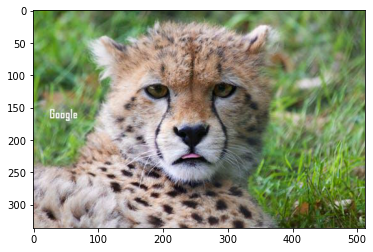

generate image:


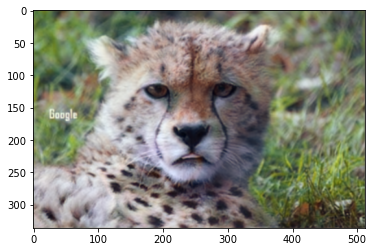

test image:


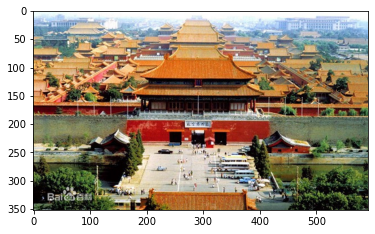

generate image:


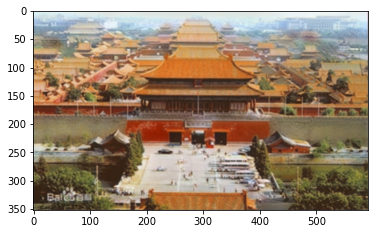

test image:


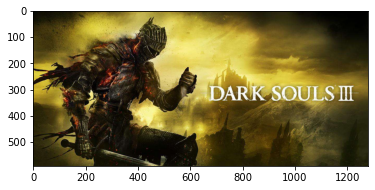

generate image:


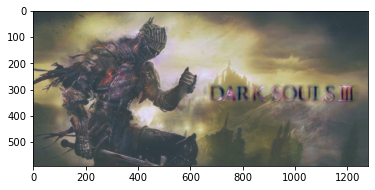

test image:


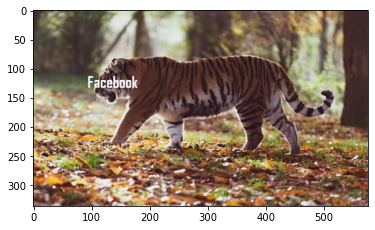

generate image:


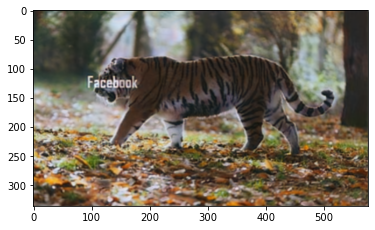

test image:


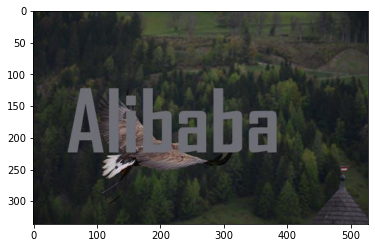

generate image:


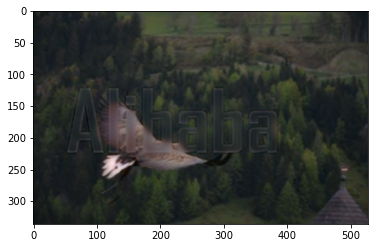

test image:


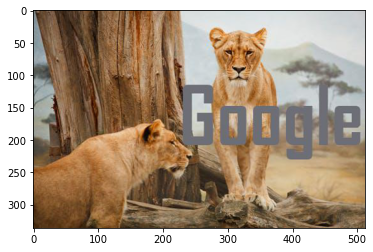

generate image:


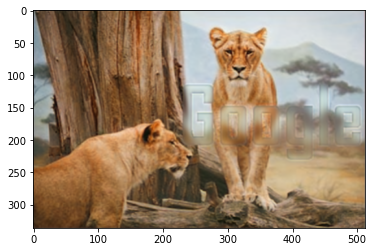

test image:


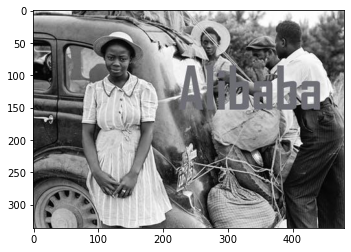

generate image:


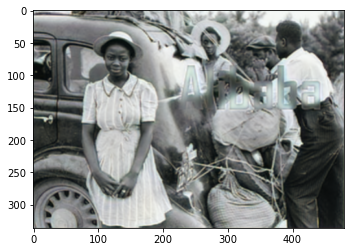

test image:


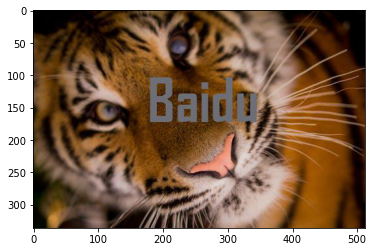

generate image:


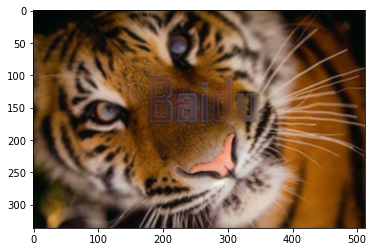

test image:


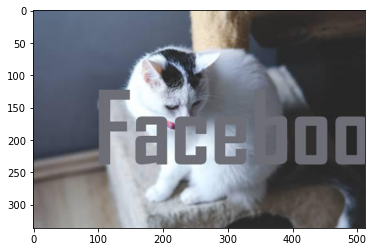

generate image:


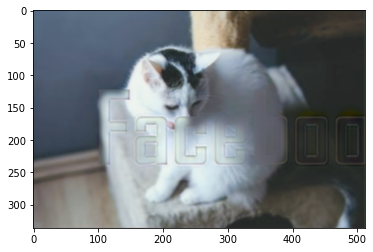

test image:


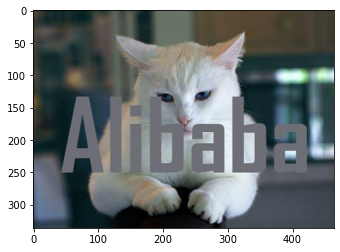

generate image:


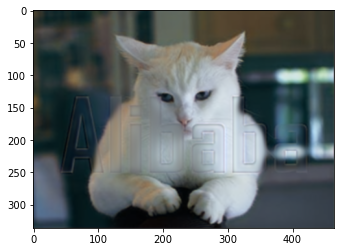

test image:


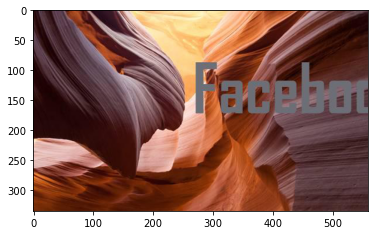

generate image:


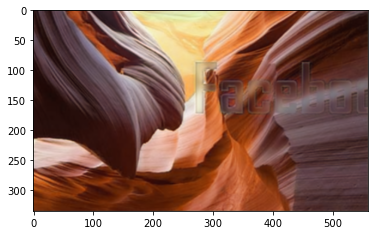

test image:


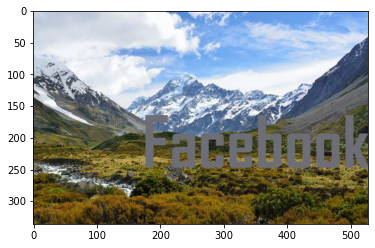

generate image:


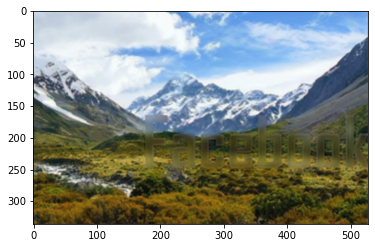

test image:


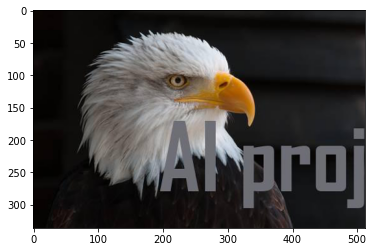

generate image:


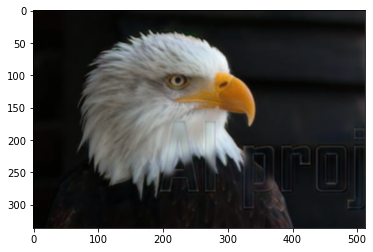

test image:


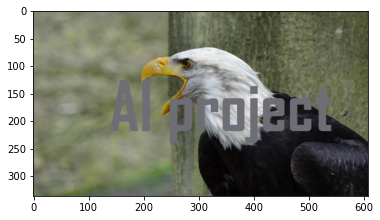

generate image:


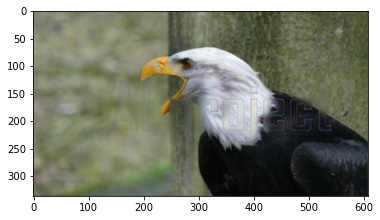

IndexError: list index out of range

In [22]:
def read_img(img,w,h):

    img=np.transpose(img, (2, 1, 0))


    img=img.reshape(1,3,(w-w%16),(h-h%16))#reshape to fit training type
    #img=img.reshape(1,3,128,128)#reshape to fit training type
    img=img/255
    img=torch.tensor(img,dtype=torch.float32)
    if torch.cuda.is_available():
        img=img.cuda()

    img=G(img)
    img=(img-img.min())/(img.max()-img.min())
    return img

def test(G,path):
    print("test image:")
    img=np.array(Image.open(path))
    h=img.shape[0]
    w=img.shape[1]
    img =cv2.resize(img, ((int)(w-w%16),(int)(h-h%16)), interpolation = cv2.INTER_CUBIC)#make sure it can be divided by 16
    #img =cv2.resize(img, (128,128), interpolation = cv2.INTER_CUBIC)#make sure it can be divided by 16

    plt.imshow(img)
    plt.show()

    print("generate image:")
    img=read_img(img,w,h)
    plt.imshow(np.transpose(img.cpu().detach().numpy().reshape(3,(w-w%16),(h-h%16)),[2,1,0]))
    #plt.imshow(np.transpose(img.cpu().detach().numpy().reshape(3,128,128),[2,1,0]))
    plt.show()
path2="C:/Users/29503/mi"
#test function is used to test generator and print the generated image
for i in range(15):
    test(G,path2+"/"+os.listdir(path2)[i])
#test(G,"../marked_images/animal-cute-kitten-cat.jpg")
#test(G,"../mi/3791adab91aa853048bec7708ac5197.jpg")
#test(G,"../mi/29255da766dbea19e0e1b6fa32eb3d1.jpg")
#test(G,"../marked_images/animal-ara-macao-beak-bird-40984.jpeg")

In [5]:
import  matplotlib.pyplot as plt

def show_img(no_watermark_img,watermark_img,generate_img):#show image while training process
    print("no_watermark_img")
    plt.imshow(np.transpose(no_watermark_img.cpu().numpy().reshape(3,(int)(w-w%16),(int)(h-h%16)),[2,1,0]))
    #plt.imshow(np.transpose(no_watermark_img.cpu().numpy().reshape(3,128,128),[2,1,0]))
    plt.show()

    print("watermark_img")
    plt.imshow(np.transpose(watermark_img.cpu().numpy().reshape(3,(int)(w-w%16),(int)(h-h%16)),[2,1,0]))
    #plt.imshow(np.transpose(watermark_img.cpu().numpy().reshape(3,128,128),[2,1,0]))
    plt.show()

    print("generate_img")
    generate_img=(generate_img-generate_img.min())/(generate_img.max()-generate_img.min())
    plt.imshow(np.transpose(generate_img.cpu().detach().numpy().reshape(3,(int)(w-w%16),(int)(h-h%16)),[2,1,0]))
    #plt.imshow(np.transpose(generate_img.cpu().detach().numpy().reshape(3,128,128),[2,1,0]))
    plt.show()

In [9]:

with open('duplicate_list_big_dataset.pk', 'rb') as f:
  dup=pickle.load(f)

In [7]:

import os
from PIL import Image
import  matplotlib.pyplot as plt
import numpy as np
import cv2
#first time traning
epoch=500
count=0
path1="./image"# path1 denotes path to store  no watermark image
path2="./marked_images"# path2 denotes path to store  watermark image
for i in range(epoch):
    for name in os.listdir(path2):
    
        no_watermark_img=np.array(Image.open(path1+"/"+name))

        h=no_watermark_img.shape[0]#
        w=no_watermark_img.shape[1]
        #no_watermark_img =cv2.resize(no_watermark_img, (128,128), interpolation = cv2.INTER_CUBIC)#make sure it can be divided by 16
        no_watermark_img =cv2.resize(no_watermark_img, ((int)(w-w%16),(int)(h-h%16)), interpolation = cv2.INTER_CUBIC)
        no_watermark_img=np.transpose(no_watermark_img, (2, 1, 0))


        #no_watermark_img=no_watermark_img.reshape(1,3,128,128)#reshape to fit training type
        no_watermark_img=no_watermark_img.reshape(1,3,(int)(w-w%16),(int)(h-h%16))
        no_watermark_img=no_watermark_img/255
        no_watermark_img=torch.tensor(no_watermark_img,dtype=torch.float32)#preprocess the image and convert it to tensor

        watermark_img=np.array(Image.open(path2+"/"+name))
        h=watermark_img.shape[0]#
        w=watermark_img.shape[1]
        #watermark_img =cv2.resize(watermark_img, (128,128), interpolation = cv2.INTER_CUBIC)
        watermark_img =cv2.resize(watermark_img, ((int)(w-w%16),(int)(h-h%16)), interpolation = cv2.INTER_CUBIC)
        watermark_img=np.transpose(watermark_img, (2, 1, 0))


        #watermark_img=watermark_img.reshape(1,3,128,128)
        watermark_img=watermark_img.reshape(1,3,(int)(w-w%16),(int)(h-h%16))
        watermark_img=watermark_img/255
        watermark_img=torch.tensor(watermark_img,dtype=torch.float32)#preprocess the image and convert it to tensor

        if torch.cuda.is_available():
            no_watermark_img=no_watermark_img.cuda()
            watermark_img=watermark_img.cuda()

        #train G
        g_optimizer.zero_grad()
        generate_img=G(watermark_img)
        generate_img=(generate_img-generate_img.min())/(generate_img.max()-generate_img.min())
        g_loss=G_loss(no_watermark_img,generate_img,watermark_img,D,G,vgg)
        g_loss.backward()
        g_optimizer.step()

        #train D
        d_optimizer.zero_grad()
        generate_img=G(watermark_img)
        generate_img=(generate_img-generate_img.min())/(generate_img.max()-generate_img.min())
        d_loss=D_loss(no_watermark_img,generate_img,watermark_img,D,G)
        d_loss.backward()
        d_optimizer.step()
        if(count%500==0):
            print("d_loss:",d_loss)
            print("g_loss:",g_loss)
        
        if(count%668==0):#After training for a while, look at the image to see what's happening.
            show_img(no_watermark_img,watermark_img,generate_img)
      #print the latest result to check.
        count+=1
    print("epoch:{}".format(i))

    if((i+1)%250==0):
        torch.save(D, './model/D{}_6images_yuan.pkl'.format(i+250))  # save entire net
        torch.save(G, './model/G{}_6images_yuan.pkl'.format(i+250))  # save entire net



FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:/Users/29503/mi'